In [1]:
import yaml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from hyperparam_scan_util import GridScan
pd.set_option('display.max_columns', None)

In [2]:
scan = GridScan.load("main", root="results")

In [3]:
def get_trials_df():
    trials = []
    for trial in scan.load_trials().values():
        trial_dict = {
            "run_id": trial.run_id,
            "trial_index": trial.index,
            "started_at": trial.started_at,
            "finished_at": trial.finished_at,
            "duration": trial.duration,
            "error": trial.error,
        }

        for key, value in trial.config.items():
            trial_dict[f"config.{key}"] = value

        for key, value in trial.metrics.items():
            if key == "epochs":
                continue
            trial_dict[f"metrics.{key}"] = value

        trials.append(trial_dict)

    return pd.DataFrame(trials)

trials_df = get_trials_df()
trials_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7 entries, 0 to 6
Columns: 119 entries, run_id to metrics.silent_neurons_first_max_std
dtypes: float64(101), int64(13), object(5)
memory usage: 6.6+ KB


In [4]:
trials_df.head()

,run_id,trial_index,started_at,finished_at,duration,error,config.seed,config.tau,config.I0,config.eps,config.Nin_virtual,config.Nhidden,config.Nlayer,config.Nout,config.w_scale,config.T,config.K,config.dt,config.gamma,config.Nbatch,config.lr,config.tau_lr,config.beta1,config.beta2,config.p_flip,config.Nepochs,config.Ntrain,config.Nt,config.Nin_data,config.Nsamples,config.Nin,metrics.acc_init_mean,metrics.acc_init_std,metrics.acc_final_mean,metrics.acc_final_std,metrics.acc_min_epoch,metrics.acc_min_mean,metrics.acc_min_std,metrics.acc_max_epoch,metrics.acc_max_mean,metrics.acc_max_std,metrics.acc_ord_init_mean,metrics.acc_ord_init_std,metrics.acc_ord_final_mean,metrics.acc_ord_final_std,metrics.acc_ord_min_epoch,metrics.acc_ord_min_mean,metrics.acc_ord_min_std,metrics.acc_ord_max_epoch,metrics.acc_ord_max_mean,metrics.acc_ord_max_std,metrics.activity_init_mean,metrics.activity_init_std,metrics.activity_final_mean,metrics.activity_final_std,metrics.activity_min_epoch,metrics.activity_min_mean,metrics.activity_min_std,metrics.activity_max_epoch,metrics.activity_max_mean,metrics.activity_max_std,metrics.activity_first_init_mean,metrics.activity_first_init_std,metrics.activity_first_final_mean,metrics.activity_first_final_std,metrics.activity_first_min_epoch,metrics.activity_first_min_mean,metrics.activity_first_min_std,metrics.activity_first_max_epoch,metrics.activity_first_max_mean,metrics.activity_first_max_std,metrics.loss_init_mean,metrics.loss_init_std,metrics.loss_final_mean,metrics.loss_final_std,metrics.loss_min_epoch,metrics.loss_min_mean,metrics.loss_min_std,metrics.loss_max_epoch,metrics.loss_max_mean,metrics.loss_max_std,metrics.loss_ord_init_mean,metrics.loss_ord_init_std,metrics.loss_ord_final_mean,metrics.loss_ord_final_std,metrics.loss_ord_min_epoch,metrics.loss_ord_min_mean,metrics.loss_ord_min_std,metrics.loss_ord_max_epoch,metrics.loss_ord_max_mean,metrics.loss_ord_max_std,metrics.perf.compilation_time_mean,metrics.perf.compilation_time_std,metrics.perf.optim_init_time_mean,metrics.perf.optim_init_time_std,metrics.perf.phi0_init_time_mean,metrics.perf.phi0_init_time_std,metrics.perf.weights_init_time_mean,metrics.perf.weights_init_time_std,metrics.silent_neurons_init_mean,metrics.silent_neurons_init_std,metrics.silent_neurons_final_mean,metrics.silent_neurons_final_std,metrics.silent_neurons_min_epoch,metrics.silent_neurons_min_mean,metrics.silent_neurons_min_std,metrics.silent_neurons_max_epoch,metrics.silent_neurons_max_mean,metrics.silent_neurons_max_std,metrics.silent_neurons_first_init_mean,metrics.silent_neurons_first_init_std,metrics.silent_neurons_first_final_mean,metrics.silent_neurons_first_final_std,metrics.silent_neurons_first_min_epoch,metrics.silent_neurons_first_min_mean,metrics.silent_neurons_first_min_std,metrics.silent_neurons_first_max_epoch,metrics.silent_neurons_first_max_mean,metrics.silent_neurons_first_max_std
0,20240904_201357,0,2024-09-04_20-13-57_082724,2024-09-04_20-14-23_353989,26.271265,None,0,1.909859,1.25,0.000001,16,40,2,20,0.5,2.0,100,0.001,0.01,1000,0.004,100.0,0.9,0.999,0.0,1,None,10,700,1,7000,0.043626,0.0,0.303849,0.0,0.0,0.043626,0.0,1.0,0.303849,0.0,0.043626,0.0,0.046414,0.0,0.0,0.043626,0.0,1.0,0.046414,0.0,0.000300,0.0,0.224100,0.0,0.0,0.000300,0.0,1.0,0.224100,0.0,0.000300,0.0,0.224100,0.0,0.0,0.000300,0.0,1.0,0.224100,0.0,3.033309,0.0,2.730953,0.0,1.0,2.730953,0.0,0.0,3.033309,0.0,3.012915,0.0,3.012915,0.0,0.0,3.012915,0.0,0.0,3.012915,0.0,0.000441,0.0,0.041880,0.0,0.069990,0.0,0.458684,0.0,0.950,0.0,0.375,0.0,1.0,0.375,0.0,0.0,0.950,0.0,0.950,0.0,0.375,0.0,1.0,0.375,0.0,0.0,0.950,0.0
1,20240904_202207,0,2024-09-04_20-22-07_478839,2024-09-04_20-22-51_929755,44.450916,None,0,1.909859,1.25,0.000001,16,40,2,20,0.5,2.0,100,0.001,0.01,1000,0.004,100.0,0.9,0.999,0.0,1,None,15,700,1,10500,0.043626,0.0,0.309343,0.0,0.0,0.043626,0.0,1.0,0.309343,0.0,0.043626,0.0,0.066394,0.0,0.0,0.043626,0.0,1.0,0.066394,0.0,0.000000,0.0,0.272750,0.0,0.0,0.000000,0.0,1.0,0.272750,0.0,0.000000,

In [5]:
# def load_trials_df(version: int):
#     filename = f"grid_data_{version:02d}.yaml"

#     with open(filename, "r") as f:
#         data = yaml.safe_load(f)

#     trials = []

#     for trial in data["trials"].values():
#         for k, v in trial["config"].items():
#             trial[f"config.{k}"] = v
#         del trial["config"]

#         for k, v in trial["metrics"].items():
#             trial[f"metrics.{k}"] = v
#         del trial["metrics"]

#         trials.append(trial)

#     return pd.DataFrame(trials)

# trials_df = load_trials_df(version=1)
# trials_df.info()

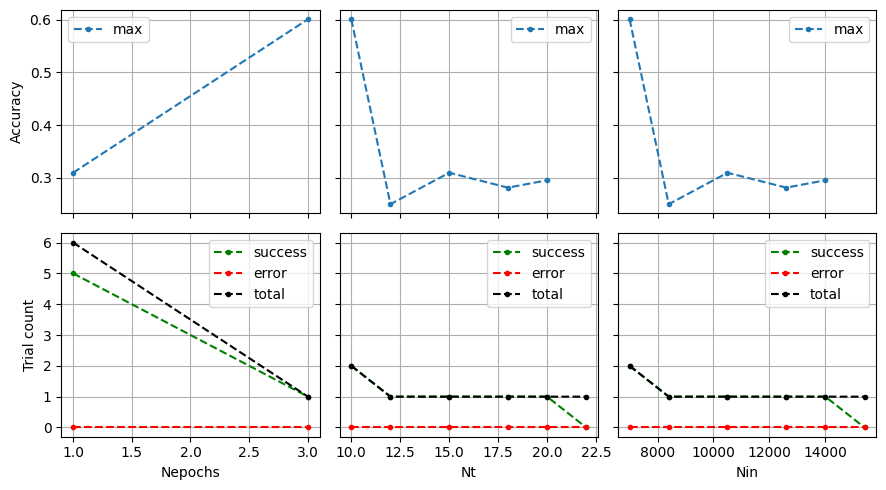

In [6]:
def plot_config_dependency(df, agg_funcs=("max",), agg_kwargs=dict(numeric_only=True)):
    config_cols = [
        col
        for col in df.columns
        if col.startswith("config.") and df[col].nunique() > 1
    ]

    fig, axs = plt.subplots(2, len(config_cols), figsize=(3 * len(config_cols), 5), sharey="row", sharex="col", squeeze=False)

    for (agg_ax, count_ax), config_col in zip(axs.T, config_cols):
        grouped = df.groupby(config_col)

        for agg_func in agg_funcs:
            agg_df = grouped.aggregate(agg_func, **agg_kwargs)
            
            agg_df.plot(
                ax=agg_ax,
                y="metrics.acc_max_mean",
                marker=".",
                linestyle="--",
                label=agg_func,
            )

        grouped.count().plot(
            ax=count_ax,
            y="metrics.acc_max_mean",
            marker=".",
            linestyle="--",
            label="success",
            color="green",
        )
        grouped.count().plot(
            ax=count_ax,
            y="error",
            marker=".",
            linestyle="--",
            label="error",
            color="red",
        )
        grouped.size().plot(
            ax=count_ax,
            marker=".",
            linestyle="--",
            label="total",
            color="black",
        )

        agg_ax.set_ylabel("Accuracy")
        agg_ax.grid()
        agg_ax.legend()

        count_ax.set_xlabel(config_col.removeprefix("config."))
        count_ax.set_ylabel("Trial count")
        count_ax.grid()
        count_ax.legend()

    plt.tight_layout()
    plt.show()

plot_config_dependency(trials_df)

The problem with these graphs is that we cannot really determine which config parameters lead to which accuracy change.
For this, we have to fix all config parameters, except one and plot the accuracy against the single free parameter.

Creating 2x1 subplots


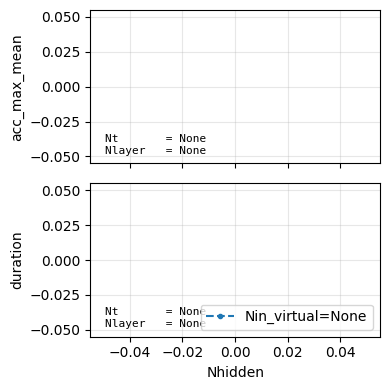

In [7]:
def get_config_val_list(df, key, min_count=0) -> list:
    if not key:
        return []

    col = f"config.{key}"
    val_counts = df[col].value_counts()
    return val_counts[val_counts >= min_count].index.sort_values().to_list()

def plot_single_config_key_dependency(
    df,
    free_key, col_key=None, row_key=None, graph_key=None,
    fixed_values: dict = {}, ignore_keys=(),
    y_cols=("metrics.acc_max_mean",),
    min_points_per_val=0,
):
    # Filter fixed values
    for key, value in fixed_values.items():
        df = df[df[f"config.{key}"] == value]

    config_keys = [
        key.removeprefix("config.")
        for key in df.columns
        if key.startswith("config.")
    ]
        
    for key in config_keys:
        if key in (free_key, col_key, row_key, graph_key, *ignore_keys):
            continue

        if len(val_counts := df[f"config.{key}"].value_counts()) > 1:
            most_freq_val = val_counts.idxmax()
            print(f"Key {key} has multiple values {val_counts.index.to_list()}. Using most frequent value: {most_freq_val}")
            df = df[df[f"config.{key}"] == most_freq_val]

    
    col_vals = get_config_val_list(df, col_key, min_points_per_val) or [None]
    # print("col_vals =", col_vals)
    row_vals = get_config_val_list(df, row_key, min_points_per_val) or [None]
    # print("row_vals =", row_vals)
    graph_vals = get_config_val_list(df, graph_key, min_points_per_val) or [None]
    # print("graph_vals =", graph_vals)

    fig, axs = plt.subplots(
        len(row_vals) * len(y_cols), len(col_vals),
        figsize=(4 * len(col_vals), 2 * len(row_vals) * len(y_cols)),
        sharey="row", sharex="col", squeeze=False
    )

    print(f"Creating {axs.shape[0]}x{axs.shape[1]} subplots")

    for row_i, col_i, y_i in np.ndindex(len(row_vals), len(col_vals), len(y_cols)):
        row_val = row_vals[row_i]
        col_val = col_vals[col_i]
        y_col = y_cols[y_i]
        ax = axs[row_i * len(y_cols) + y_i, col_i]

        plot_vals = {}
        if row_key:
            plot_vals[row_key] = row_val
        if col_key:
            plot_vals[col_key] = col_val
            
        ax_df = df
        for key, value in plot_vals.items():
            ax_df = ax_df[ax_df[f"config.{key}"] == value]

        
        ax.text(0.05, 0.05, "\n".join(f"{key:<8} = {value}" for key, value in plot_vals.items()),
                transform=ax.transAxes, fontsize=8, va="bottom", ha="left", family="monospace")
        # max_acc = ax_df["metrics.acc_max_mean"].max().max()
        # ax.text(0.05, 0.05, f"max: {max_acc:.3f}", transform=ax.transAxes, fontsize=8, va="bottom", ha="left")


        for graph_val in graph_vals:
            graph_df = ax_df

            if graph_val is not None:
                graph_df = graph_df[graph_df[f"config.{graph_key}"] == graph_val]

            graph_df.plot(
                ax=ax,
                x=f"config.{free_key}",
                y=y_col,
                xlabel=free_key,
                marker=".",
                linestyle="--",
                label=f"{graph_key}={graph_val}" if graph_key else None,
                legend=False
            )
            
        ax.grid(alpha=.3)
        ax.set_ylabel(y_col.removeprefix("metrics."))

    if graph_key:
        axs[-1, -1].legend(loc="lower right")

    plt.tight_layout()
    plt.show()


plot_single_config_key_dependency(
    trials_df,
    y_cols=("metrics.acc_max_mean", "duration"),
    free_key="Nhidden",
    col_key="Nlayer",
    row_key="Nt",
    graph_key="Nin_virtual",
    fixed_values={"K": 300, "p_flip": 0},
    ignore_keys=("Nin",) # Nin is computed from Nin_virtual and Nt
)

## Dependence of accuracy on `K`

Creating 1x1 subplots


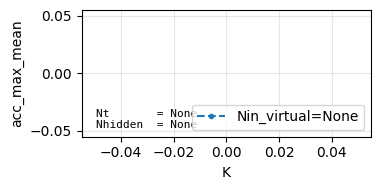

In [8]:
plot_single_config_key_dependency(
    trials_df,
    y_cols=("metrics.acc_max_mean",),
    free_key="K",
    col_key="Nhidden",
    row_key="Nt",
    graph_key="Nin_virtual",
    fixed_values={"p_flip": 0, "Nlayer": 2},
    ignore_keys=("Nin", "Nepochs"), # Nin is computed from Nin_virtual and Nt
    min_points_per_val=10
)

Here, we can see that the accuracy is essentially independent of `K`, assuming that `K` is sufficiently high. The case for insufficiently high `K` can be seen for high `Nhidden` on the right.

## Dependence of accuracy and duration on `N_t`

Creating 2x1 subplots


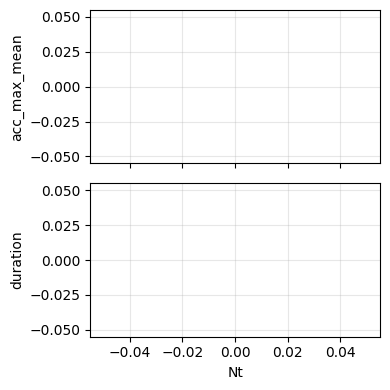

In [9]:
plot_single_config_key_dependency(
    trials_df,
    y_cols=("metrics.acc_max_mean", "duration"),
    free_key="Nt",
    fixed_values={"p_flip": 0, "Nhidden": 200, "Nin_virtual": 24, "Nlayer": 2, "Nepochs": 20},
    ignore_keys=("Nin", "K") # Nin is computed from Nin_virtual and Nt
)

The accuracy plateaus above around `Nt = 7`. The duration on the other hand roughly increases linearly with `Nt`. It should therefore be best to choose a fixed `Nt` (e.g. around 10).

## Best trials

In [10]:
trials_df.sort_values("metrics.acc_max_mean", ascending=False).head(10)

,run_id,trial_index,started_at,finished_at,duration,error,config.seed,config.tau,config.I0,config.eps,config.Nin_virtual,config.Nhidden,config.Nlayer,config.Nout,config.w_scale,config.T,config.K,config.dt,config.gamma,config.Nbatch,config.lr,config.tau_lr,config.beta1,config.beta2,config.p_flip,config.Nepochs,config.Ntrain,config.Nt,config.Nin_data,config.Nsamples,config.Nin,metrics.acc_init_mean,metrics.acc_init_std,metrics.acc_final_mean,metrics.acc_final_std,metrics.acc_min_epoch,metrics.acc_min_mean,metrics.acc_min_std,metrics.acc_max_epoch,metrics.acc_max_mean,metrics.acc_max_std,metrics.acc_ord_init_mean,metrics.acc_ord_init_std,metrics.acc_ord_final_mean,metrics.acc_ord_final_std,metrics.acc_ord_min_epoch,metrics.acc_ord_min_mean,metrics.acc_ord_min_std,metrics.acc_ord_max_epoch,metrics.acc_ord_max_mean,metrics.acc_ord_max_std,metrics.activity_init_mean,metrics.activity_init_std,metrics.activity_final_mean,metrics.activity_final_std,metrics.activity_min_epoch,metrics.activity_min_mean,metrics.activity_min_std,metrics.activity_max_epoch,metrics.activity_max_mean,metrics.activity_max_std,metrics.activity_first_init_mean,metrics.activity_first_init_std,metrics.activity_first_final_mean,metrics.activity_first_final_std,metrics.activity_first_min_epoch,metrics.activity_first_min_mean,metrics.activity_first_min_std,metrics.activity_first_max_epoch,metrics.activity_first_max_mean,metrics.activity_first_max_std,metrics.loss_init_mean,metrics.loss_init_std,metrics.loss_final_mean,metrics.loss_final_std,metrics.loss_min_epoch,metrics.loss_min_mean,metrics.loss_min_std,metrics.loss_max_epoch,metrics.loss_max_mean,metrics.loss_max_std,metrics.loss_ord_init_mean,metrics.loss_ord_init_std,metrics.loss_ord_final_mean,metrics.loss_ord_final_std,metrics.loss_ord_min_epoch,metrics.loss_ord_min_mean,metrics.loss_ord_min_std,metrics.loss_ord_max_epoch,metrics.loss_ord_max_mean,metrics.loss_ord_max_std,metrics.perf.compilation_time_mean,metrics.perf.compilation_time_std,metrics.perf.optim_init_time_mean,metrics.perf.optim_init_time_std,metrics.perf.phi0_init_time_mean,metrics.perf.phi0_init_time_std,metrics.perf.weights_init_time_mean,metrics.perf.weights_init_time_std,metrics.silent_neurons_init_mean,metrics.silent_neurons_init_std,metrics.silent_neurons_final_mean,metrics.silent_neurons_final_std,metrics.silent_neurons_min_epoch,metrics.silent_neurons_min_mean,metrics.silent_neurons_min_std,metrics.silent_neurons_max_epoch,metrics.silent_neurons_max_mean,metrics.silent_neurons_max_std,metrics.silent_neurons_first_init_mean,metrics.silent_neurons_first_init_std,metrics.silent_neurons_first_final_mean,metrics.silent_neurons_first_final_std,metrics.silent_neurons_first_min_epoch,metrics.silent_neurons_first_min_mean,metrics.silent_neurons_first_min_std,metrics.silent_neurons_first_max_epoch,metrics.silent_neurons_first_max_mean,metrics.silent_neurons_first_max_std
6,20240904_203628,0,2024-09-04_20-36-29_379063,2024-09-04_20-37-21_644714,52.265651,None,0,1.909859,1.25,0.000001,16,40,2,20,0.5,2.0,100,0.001,0.01,1000,0.004,100.0,0.9,0.999,0.0,3,None,10,700,1,7000,0.043626,0.0,0.601091,0.0,0.0,0.043626,0.0,3.0,0.601091,0.0,0.043626,0.0,0.050606,0.0,0.0,0.043626,0.0,2.0,0.073465,0.0,0.000300,0.0,0.293483,0.0,0.0,0.000300,0.0,3.0,0.293483,0.0,0.000300,0.0,0.293458,0.0,0.0,0.000300,0.0,3.0,0.293458,0.0,3.033309,0.0,1.642242,0.0,3.0,1.642242,0.0,0.0,3.033309,0.0,3.012915,0.0,3.012772,0.0,2.0,3.010460,0.0,0.0,3.012915,0.0,0.000639,0.0,0.047206,0.0,0.076364,0.0,0.523712,0.0,0.950,0.0,0.150,0.0,3.0,0.150,0.0,0.0,0.950,0.0,0.950,0.0,0.150,0.0,3.0,0.150,0.0,0.0,0.950,0.0
1,20240904_202207,0,2024-09-04_20-22-07_478839,2024-09-04_20-22-51_929755,44.450916,None,0,1.909859,1.25,0.000001,16,40,2,20,0.5,2.0,100,0.001,0.01,1000,0.004,100.0,0.9,0.999,0.0,1,None,15,700,1,10500,0.043626,0.0,0.309343,0.0,0.0,0.043626,0.0,1.0,0.309343,0.0,0.043626,0.0,0.066394,0.0,0.0,0.043626,0.0,1.0,0.066394,0.0,0.000000,0.0,0.272750,0.0,0.0,0.000000,0.0,1.0,0.272750,0.0,0.000000,

In [11]:
best_trial = trials_df.loc[trials_df["metrics.acc_max_mean"].idxmax()]
print("===== BEST TRIAL =====")
print(best_trial[[
    "index", "duration",
    "metrics.acc_max_mean", "metrics.acc_max_std", "metrics.acc_max_epoch"
]])
best_config = {
    k.removeprefix("config."): v.item() if isinstance(v, np.generic) else v
    for k, v in best_trial.items()
    if isinstance(k, str) and k.startswith("config.")
}
print("Config:", best_config)

===== BEST TRIAL =====


KeyError: "['index'] not in index"